In [1]:
%%time
import datetime

print('Starting at', datetime.datetime.now())

Starting at 2020-11-24 14:04:48.484290
CPU times: user 167 µs, sys: 16 µs, total: 183 µs
Wall time: 144 µs


In [2]:
import sys

!{sys.executable} -m pip install -r requirements.txt
!{sys.executable} -m pip install pyarrow

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
%%time
import boto3
import sagemaker

session = sagemaker.Session() 
region = session.boto_region_name 

bucket = 'sagemaker-jfox'
algo =  'linearlearner'
prefix = 'sagemaker/'+algo
role = sagemaker.get_execution_role()
print('Role', role)
print(f'Bucket {bucket} in region {region}')

Role arn:aws:iam::649592902942:role/service-role/AmazonSageMaker-ExecutionRole-20201021T144991
Bucket sagemaker-jfox in region eu-west-1
CPU times: user 698 ms, sys: 133 ms, total: 832 ms
Wall time: 2.87 s


In [4]:
%%time
import random
import pandas as pd
import pyarrow.parquet as pq
import os 

raw_data_filename = 'frauddetection.parquet.snappy'
 
s3 = boto3.resource('s3', region_name=region)

s3_path_snappy = 'prepareddataalltypes/datapreparation_20Nov2020_1605858525820/datapreparation_20Nov2020_1605858525820_part00000.parquet.snappy'

if not os.path.isfile(raw_data_filename):
   s3.Bucket(bucket).download_file(s3_path_snappy,  raw_data_filename)
 

CPU times: user 90.1 ms, sys: 12.3 ms, total: 102 ms
Wall time: 1.11 s


In [5]:
%%time 
table = pq.read_table(raw_data_filename)
df = table.to_pandas()
 
pd.set_option('display.max_rows', 10) 
 
print(len(df), 'data items')

6362620 data items
CPU times: user 1.13 s, sys: 864 ms, total: 1.99 s
Wall time: 670 ms


In [6]:
target_col = 'Fraudulent'

In [7]:

df = df.rename(columns = {'isFraud': target_col,
                          'type_CASH_OUT': 'type_CashOut',
                          'type_TRANSFER': 'type_Transfer',
                          'type_CASH_IN': 'type_CashIn',
                          'type_PAYMENT': 'type_Payment',
                          'oldbalanceOrg_nml': 'originOldBalance',
                          'oldBalanceOrigSign': 'originOldBalanceSign', 
                          'newbalanceOrig_nml': 'originNewBalance',
                          'negDeltaOrigin_nml': 'negativeDeltaInOrigin', 
                          'oldbalanceDest_nml': 'destinationOldBalance',
                          'newbalanceDest_nml': 'destinationNewBalance',
                          'expectedNewBalDest_nml': 'destinationExpectedNewBalance', # based on old value and delta   
                          'amount_nml': 'amount',
                          'hourOf24_radians': 'hourOf24_radians',# To be deleted after calculation
                          'isFlaggedFraud':'FlaggedFraud'#To be deleted
                         })


`type_X` columns where X in  `PAYMENT` `TRANSFER` `CASH_OUT` `DEBIT` `CASH_IN`
There was also `DEBIT`, but onehotting drops one of the types because of correlation.
All `isFraud` rows have `type` `TRANSFER` or `CASH_OUT`, never  `CASH_IN` or `PAYMENT` or `DEBIT`

Counts of each class to determine imbalance.

In [8]:
def count_positive_and_negative(df):
    num_positive = len(df.loc[  df[target_col] == 1 ])
    num_negative = len(df) - num_positive
    return num_positive, num_negative

num_positive, num_negative = count_positive_and_negative(df)

print('Fraud', num_positive, '; Not fraud', num_negative, '; Total', len(df))

Fraud 8213 ; Not fraud 6354407 ; Total 6362620


Plot distribution of positive vs negative, in log scale because of the imbalance

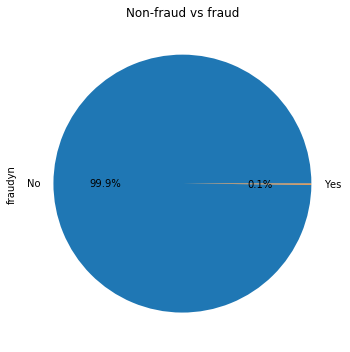

In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt   

def plot_positive_negative_counts(df, target_col):
        df['fraudyn']=np.where(df[target_col]==1, 'Yes', 'No')
        df['fraudyn'].value_counts().plot.pie(figsize=(5, 5), autopct='%.1f%%')
        plt.title('Non-fraud vs fraud')
        plt.tight_layout()
        del df['fraudyn']
    
plot_positive_negative_counts(df,target_col)

Check that target is on the left, per Sagemaker standard

In [10]:
assert target_col == df.columns.tolist()[0]

Transform hour of day to a form suited for cyclical data.

In [11]:
import numpy as np
hours_col = 'hourOf24_radians'
df['sineHourInDay'] = np.sin(df[hours_col])
df['cosineHourInDay'] = np.cos(df[hours_col])
df = df.drop(hours_col, axis=1)
df

,Fraudulent,type_CashIn,type_CashOut,type_Payment,type_Transfer,amount,originOldBalance,originOldBalanceSign,originNewBalance,negativeDeltaInOrigin,destinationOldBalance,destinationExpectedNewBalance,destinationNewBalance,sineHourInDay,cosineHourInDay
0,0,0,0,1,0,-0.281560,-0.229810,1,-0.237622,0.211876,-0.323814,-0.350732,-0.333411,0.258626,0.965977
1,0,0,0,1,0,-0.294767,-0.281359,1,-0.285812,0.157490,-0.323814,-0.352933,-0.333411,0.258626,0.965977
2,1,0,0,0,1,-0.297555,-0.288654,1,-0.292442,0.146011,-0.323814,-0.353398,-0.333411,0.258626,0.965977
3,1,0,1,0,0,-0.297555,-0.288654,1,-0.292442,0.146011,-0.317582,-0.347552,-0.333411,0.258626,0.965977
4,0,0,0,1,0,-0.278532,-0.274329,1,-0.282221,0.224345,-0.323814,-0.350227,-0.333411,0.258626,0.965977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,1,0,1,0,0,0.264665,-0.171108,1,-0.292442,2.461161,-0.323814,-0.259692,-0.240959,-0.263246,0.964729
6362616,1,0,0,0,1,10.153952,1.896491,1,-0.292442,43.183974,-0.323814,1.388562,-0.333411,-0.263246,0.964729
6362617,1,0,1,0,0,10.153952,1.896491,1,-0.292442,43.183974,-0.303665,1.407466,1.403027,-0.263246,0.964729
6362618,1,0,0,0,1,1.109765,0.005581,1,-0.292442,5.941173,-0.323814,-0.118839,-0.333411,-0.263246,0.964729


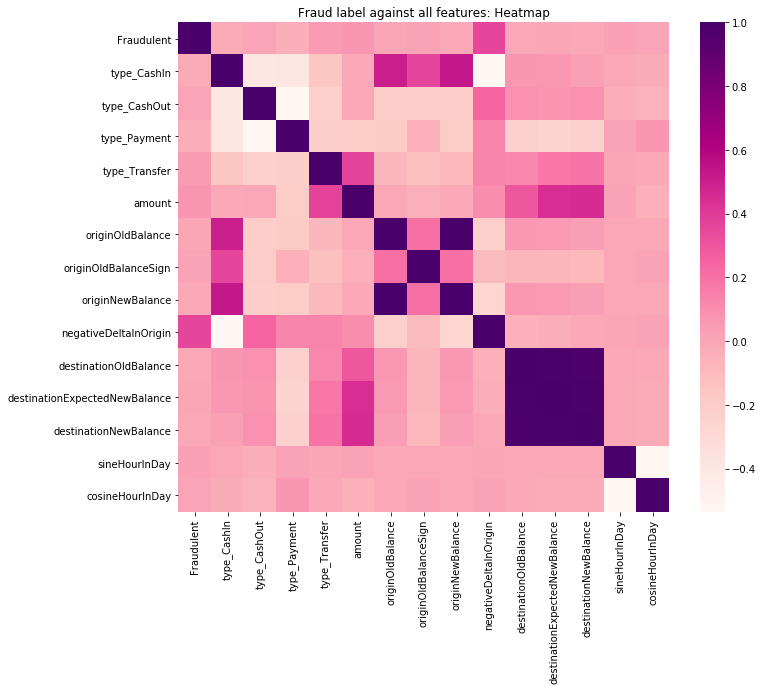

In [12]:
import seaborn  

fig, axes = plt.subplots( 1,1, figsize=(11,9))

def heatmap_all_features():
    
    lbl='Fraud label against all features'
    axes .set_title(f'{lbl}: Heatmap')
    seaborn.heatmap(df.corr(),  cmap='RdPu', ax=axes)
    
heatmap_all_features()

plt.show()

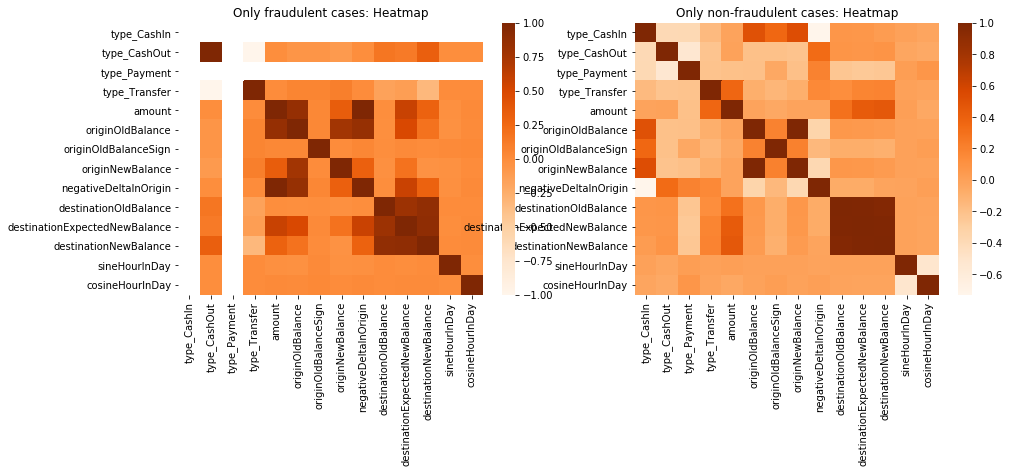

In [13]:
import seaborn  

fig, axes = plt.subplots( 1,2, figsize=(15,5))

def heatmap(fraud_cases):
    
    lbl='fraudulent' if fraud_cases else 'non-fraudulent'
    axes[1-fraud_cases].set_title(f'Only {lbl} cases: Heatmap')
    seaborn.heatmap(df.query(f'{target_col} == {fraud_cases}').drop([target_col], 1).corr(),  cmap='Oranges', ax=axes[1-fraud_cases])
    
heatmap(True)
heatmap(False)

plt.show()

# Split  with randomization

In [14]:
l=np.random.rand(10)
print(l)
train_ = l < 0.8
val_ = (l >= 0.8) & (l < 0.9)
test_ = (l >= 0.9)

print(list(train_))
print('x')
print(list(val_))
print('x')
print(list(test_))
print('x')

[0.02543102 0.38781027 0.35509596 0.30336924 0.13518071 0.97552714
 0.16226266 0.72852542 0.43496386 0.96384884]
[True, True, True, True, True, False, True, True, True, False]
x
[False, False, False, False, False, False, False, False, False, False]
x
[False, False, False, False, False, True, False, False, False, True]
x


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import time
import json
import sagemaker.amazon.common as smac
import os

rand_split = np.random.rand(len(df))
#train_cutoff = 0.8
#validation_cutoff = 0.9
#train_list = rand_split < train_cutoff
#val_list = (rand_split >= train_cutoff) & (rand_split < validation_cutoff)
#test_list = rand_split >= validation_cutoff
train_list = rand_split < 0.8
val_list = (rand_split >= 0.8) & (rand_split < 0.9)
test_list = (rand_split >= 0.9)
 
data_train = df[train_list]
data_val = df[val_list]
data_test = df[test_list]


print(f'Data: Total: {len(df):,d}; ' +
      f'Training {len(data_train):,d}; ' + 
      f'Validation: {len(data_val):,d}; ' +
      f'Testing: {len(data_test):,d}')

train_y = ( data_train.iloc[:,1]  ).to_numpy();
train_X = data_train.iloc[:,2:].to_numpy();

val_y = ( data_val.iloc[:,1]).to_numpy();
val_X = data_val.iloc[:,2:].to_numpy();

test_y =  (data_test.iloc[:,1]).to_numpy();
test_X = data_test.iloc[:,2:].to_numpy();

data_train.head(10)

Data: Total: 6,362,620; Training 5,091,553; Validation: 636,242; Testing: 634,825


,Fraudulent,type_CashIn,type_CashOut,type_Payment,type_Transfer,amount,originOldBalance,originOldBalanceSign,originNewBalance,negativeDeltaInOrigin,destinationOldBalance,destinationExpectedNewBalance,destinationNewBalance,sineHourInDay,cosineHourInDay
0,0,0,0,1,0,-0.281560,-0.229810,1,-0.237622,0.211876,-0.323814,-0.350732,-0.333411,0.258626,0.965977
1,0,0,0,1,0,-0.294767,-0.281359,1,-0.285812,0.157490,-0.323814,-0.352933,-0.333411,0.258626,0.965977
2,1,0,0,0,1,-0.297555,-0.288654,1,-0.292442,0.146011,-0.323814,-0.353398,-0.333411,0.258626,0.965977
3,1,0,1,0,0,-0.297555,-0.288654,1,-0.292442,0.146011,-0.317582,-0.347552,-0.333411,0.258626,0.965977
4,0,0,0,1,0,-0.278532,-0.274329,1,-0.282221,0.224345,-0.323814,-0.350227,-0.333411,0.258626,0.965977
5,0,0,0,1,0,-0.284908,-0.270068,1,-0.276696,0.198088,-0.323814,-0.351290,-0.333411,0.258626,0.965977
6,0,0,0,1,0,-0.286084,-0.225289,1,-0.232221,0.193247,-0.323814,-0.351486,-0.333411,0.258626,0.965977
7,0,0,0,1,0,-0.284836,-0.227750,1,-0.234910,0.198388,-0.323814,-0.351278,-0.333411,0.258626,0.965977
8,0,0,0,1,0,-0.291190,-0.287792,1,-0.292442,0.162991,-0.323814,-0.352337,-0.333411,0.258626,0.965977
9,0,0,0,0,0,-0.289015,-0.274272,1,-0.279999,0.181177,-0.311488,-0.340410,-0.322430,0.258626,0.965977


In [16]:
train_file = 'linear_train.data'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, train_X.astype('float32'), train_y.astype('float32'))
f.seek(0)
 
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', train_file)).upload_fileobj(f)

In [17]:
validation_file = 'linear_validation.data'
f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, val_X.astype('float32'), val_y.astype('float32'))
f.seek(0)
 
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation', validation_file)).upload_fileobj(f)

In [18]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


In [19]:
linear_training_params = {
    'RoleArn': role,
    'TrainingJobName': None, # Fill in this value before using the params
    'AlgorithmSpecification': {
        'TrainingImage': container,
        'TrainingInputMode': 'File'
    },
    'ResourceConfig': {
        'InstanceCount': 4,
        'InstanceType': 'ml.c4.2xlarge',
        'VolumeSizeInGB': 10
    },
    'InputDataConfig': [
        {
            'ChannelName': 'train',
            'DataSource': {
                'S3DataSource': {
                    'S3DataType': 'S3Prefix',
                    'S3Uri': 's3://{}/{}/train/'.format(bucket, prefix),
                    'S3DataDistributionType': 'ShardedByS3Key'
                }
            },
            'CompressionType': 'None',
            'RecordWrapperType': 'None'
        },
        {
            'ChannelName': 'validation',
            'DataSource': {
                'S3DataSource': {
                    'S3DataType': 'S3Prefix',
                    'S3Uri': 's3://{}/{}/validation/'.format(bucket, prefix),
                    'S3DataDistributionType': 'FullyReplicated'
                }
            },
            'CompressionType': 'None',
            'RecordWrapperType': 'None'
        }

    ],
    'OutputDataConfig': {
        'S3OutputPath': 's3://{}/{}/'.format(bucket, prefix)
    },
    'HyperParameters': {
        'feature_dim': '-999999',# Fill in this value before using the params
        'mini_batch_size': '4',
        'binary_classifier_model_selection_criteria': 'f1',
        'predictor_type': 'binary_classifier',
       # 'epochs': '10',
        'num_models': '32',
        'loss': 'absolute_loss'
    },
    'StoppingCondition': {
        'MaxRuntimeInSeconds': 60 * 60
    }
}


In [ ]:
%%time
linear_job = 'DEMO-linear-' + time.strftime('%Y-%m-%d-%H-%M-%S', time.gmtime())
print('Job name', linear_job)

linear_training_params['TrainingJobName'] = linear_job
feature_dim=len(df.columns)-2 #Why is -2 needed to match the error-message's determination of feature dim?
linear_training_params['HyperParameters']['feature_dim'] = str(feature_dim)

region = boto3.Session().region_name
sm = boto3.client('sagemaker')

sm.create_training_job(**linear_training_params)
counter = 0
status = 'InProgress'
while status == 'InProgress':
    status = sm.describe_training_job(TrainingJobName=linear_job)['TrainingJobStatus']
    print(status,counter,'min',end='; ')
    time.sleep(30)
    counter += 0.5

err_message = sm.describe_training_job(TrainingJobName=linear_job).get('FailureReason')
if err_message:
    print('Failure reason if any: {}'.format(err_message))
    
print('Done:', status)

Job name DEMO-linear-2020-11-24-14-07-09
InProgress 0 min; InProgress 0.5 min; InProgress 1.0 min; InProgress 1.5 min; InProgress 2.0 min; InProgress 2.5 min; 

---
## Host

Deploy the trained model to an endpoint.

In [ ]:
import datetime 
import time

endpoint_name = 'fraud-detect-endpoint'
training_job_name=linear_job
model_name = training_job_name + '-model'

info = session.describe_training_job(training_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
 
print(model_data)

primary_container = {
  'Image': container,
  'ModelDataUrl': model_data
}

create_model_response = session.create_model(
      name = model_name,
      role = role,
      container_defs = primary_container)


endpoint_config_name = session.create_endpoint_config(name=endpoint_name + '-config-' + datetime.datetime.now().strftime('%m%d-%H%M%S'),
                                              model_name=model_name,
                                              initial_instance_count=1,
                                              instance_type='ml.m5.xlarge',
                                              accelerator_type='ml.eia2.medium')

client = boto3.client('sagemaker')
minutes_passed = 0
try_now = True
while try_now:
  minutes_passed += 0.5
  try:
     updated_endpoint = client.update_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name)
     try_now = False
  except Exception as e:
     if 'Could not find endpoint'  in str(e):
        print('Could not find endpoint; Trying to create')
        updated_endpoint=client.create_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name)
        try_now = False
     elif 'Cannot update in-progress endpoint' in str(e):
        print(f'{minutes_passed} min: Cannot update in-progress endpoint; retrying', end='. ')
        time.sleep(30)
        try_now = True
     else:  
        raise e

endpt_status = 'Updating'
minutes_passed = 0 
while endpt_status in ['Updating', 'Creating']:
    minutes_passed += 0.5
    endpt_status = client.describe_endpoint(EndpointName=endpoint_name)['EndpointStatus']
    print(f'{minutes_passed} min: {endpt_status} endpoint; ',end='')
    time.sleep(30)

print('\nFinished creating or updating endpoint')

---

## Evaluation

Now that we have our hosted endpoint, we can generate predictions from  the  test data set.

Compared actual to predicted values of whether the transaction was a "fraud" (`1`) or not (`0`).  Then we'll produce a  confusion matrix.

In [ ]:
%%time

def np2csv(arr):
    csv = io.BytesIO()
    np.savetxt(csv, arr, delimiter=',', fmt='%g')
    ret=csv.getvalue().decode().rstrip()
    return ret

 
runtime= boto3.client('runtime.sagemaker')
#payload = np2csv(test_X)
unlimited=100_000_000_000
sample_len=unlimited


def display(data):
    print('Count', len(data), 
        '; Positives', sum(1 for y in data if y),
      '; Negatives', sum(1 for y in data if not y))

print('Test data: ', end='')
display(test_y[:sample_len])
    
def batch_predict(data, batch_size):

    def do_predict(data_):
       payload = np2csv(data_)

       response = runtime.invoke_endpoint(EndpointName=endpoint_name,
                                   ContentType='text/csv',
                                   Body=payload)
       result = json.loads(response['Body'].read().decode())

       test_pred = np.array([r['predicted_label'] for r in result['predictions']])
       test_pred = [float(num) for num in test_pred]
       assert all(t in [0.0, 1.0] for t in test_pred) , test_pred 
       test_pred_int = [round(num) for num in test_pred]
       return test_pred_int

    len_data = len(data)
    arrs = []
    
    for offset in range(0, len_data, batch_size):
        if offset + batch_size < len_data:
            results = do_predict(data[offset:(offset+batch_size)])
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:len_data]))
        sys.stdout.write('.')
        if offset%(batch_size*100) == 0:
            sys.stdout.write(f' ({offset}) ')
    return(arrs)

preds_ml = batch_predict(test_X[:sample_len], 1000)
print('\nPredictions: ', end='')
display(preds_ml)

In [ ]:
labels_ml = test_y[:sample_len]

In [ ]:
def metrics(labels_, predictions):
   print('n:', len(labels_))
   print('.', end='')
    
   assert len(labels_)==len(predictions)
   
   unmatched= sum(1 for i in range(len(predictions)) if predictions[i] != labels_[i])
   matched = sum(1 for i in range(len(predictions)) if predictions[i] != labels_[i])

   assert unmatched, 'Zero errors is very unexpected'
   error = unmatched / float(len(predictions))
   print(f'Prediction does not equal actual: {unmatched}')
   print(f'Prediction equals actual: {matched}')

   print(f'Error rate = {error:.8f}')
  
   actual_pos = sum(1 for i in range(len(labels_)) if 1 == labels_[i])
   print('.', end='')
 
   actual_neg = sum(1 for i in range(len(labels_)) if 0 == labels_[i])
   print('.', end='')

   pred_pos = sum(1 for i in range(len(predictions)) if 1 == predictions[i])
   print('.', end='')

   pred_neg = sum(1 for i in range(len(predictions)) if 0 == predictions[i])
   print('.', end='')

   true_pos = sum(1 for i in range(len(predictions)) if predictions[i] == 1 == labels_[i])
   print('.', end='')

   true_neg = sum(1 for i in range(len(predictions)) if predictions[i] == 0 == labels_[i])
   print('.', end='')

   false_pos=sum(1 for i in range(len(predictions)) if predictions[i] == 1 and 0 == labels_[i])
   print('.', end='')

   false_neg=sum(1 for i in range(len(predictions)) if predictions[i] == 0 and 1 == labels_[i])
   print('.', end='')
   
   print('\ntrue_pos', true_pos, 'false_pos', false_pos)
   print('true_neg', true_neg, 'false_neg', false_neg)

   assert  true_pos+false_pos == pred_pos
  
   recall = true_pos / (true_pos + false_neg)
   print(f'Recall = {recall:.8f}')
   precision = true_pos / (true_pos + false_pos)

   print(f'Precision = {precision:.8f}')
   if precision+recall == 0:
       f1=float('inf')
   else:
       f1 = (2 * precision * recall) / (precision + recall)
       
   print(f'F1 = {f1:.2f}')


   assert recall <= f1 <= precision or precision <= f1 <= recall  or precision==recall==0
   assert true_pos + false_neg == actual_pos
   assert true_neg + false_pos == actual_neg
   assert len(predictions)==len(labels_)
   assert actual_pos + actual_neg==len(labels_)
   assert true_neg + false_neg== pred_neg
   assert pred_pos + pred_neg==len(predictions)


In [ ]:
print('Metrics')
metrics(labels_ml, preds_ml)
 

Show confusion matrix.

In [ ]:
pd.crosstab(index=np.array(labels_ml), columns=np.array(preds_ml), rownames=['actual fraud'],  colnames=['predicted as fraud'])

Clean up to save money

In [ ]:
#session.delete_endpoint(ll_predictor.endpoint)